(50, 57)

(49, 56)

(49, 56)

(49, 56, 2)

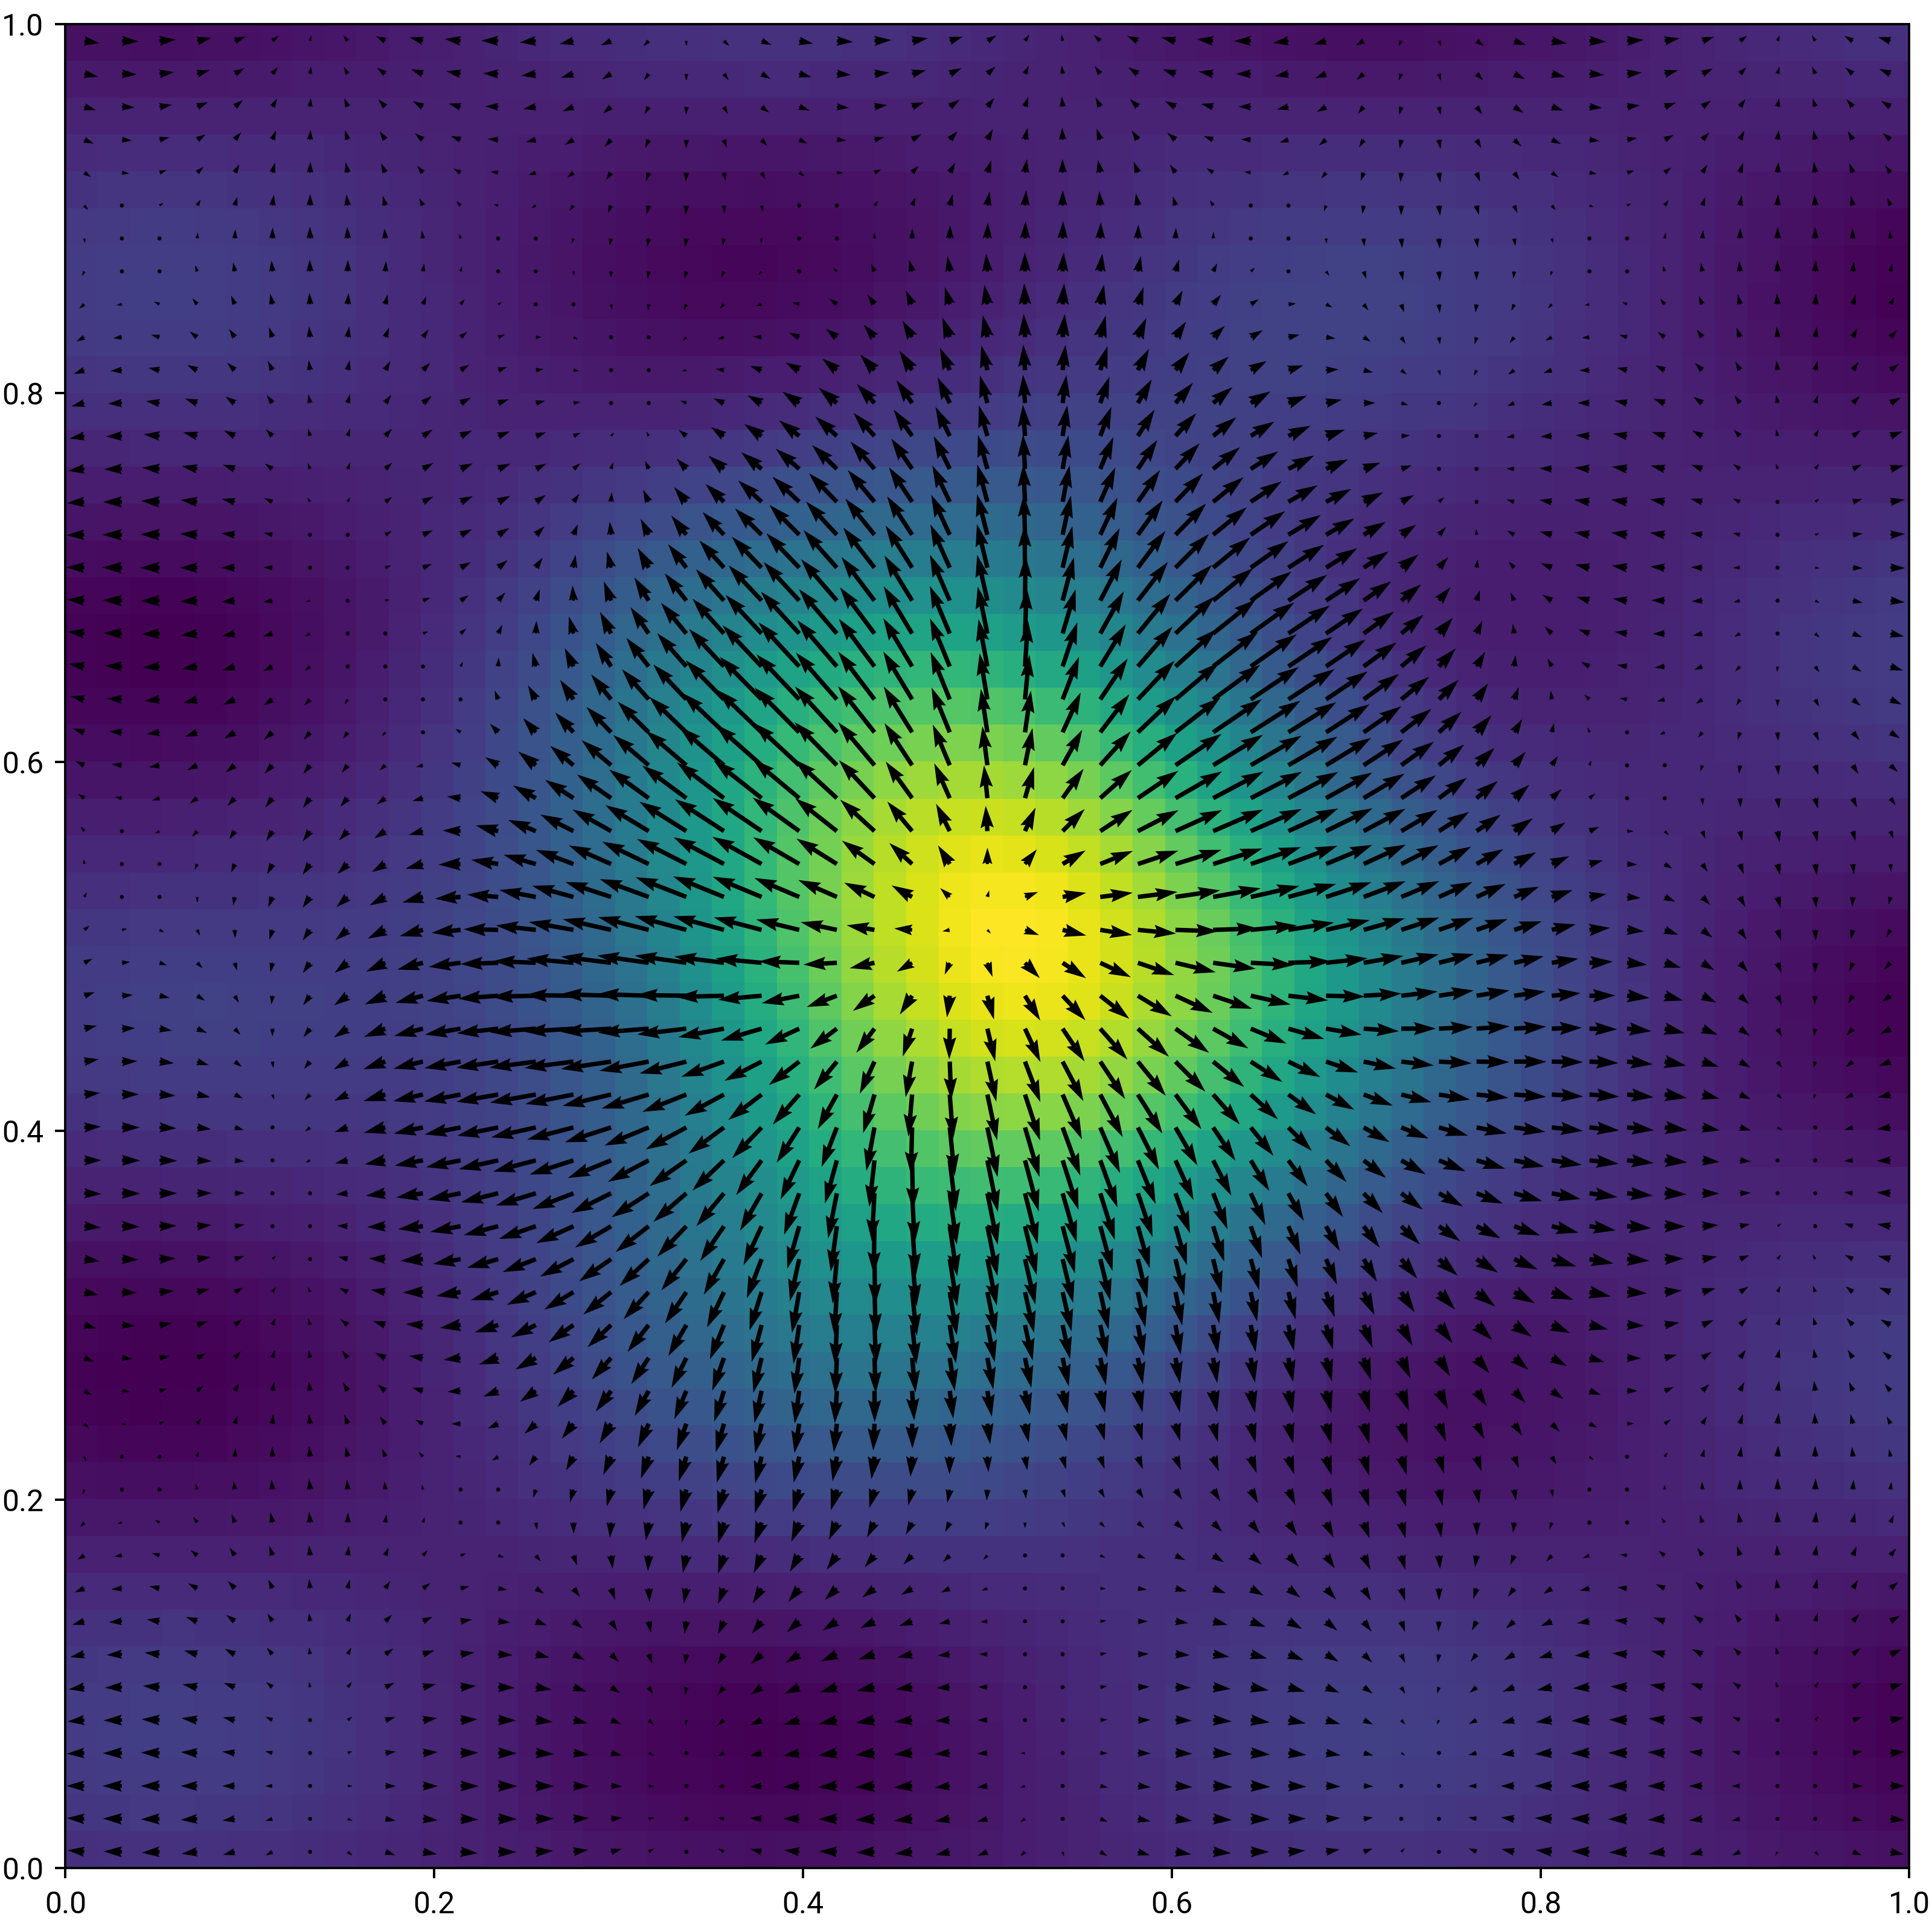

In [46]:
from joshpyutil import mpl
import numpy as np
import scipy.interpolate


n, m = 50, 57
terrain_r = 0.2
terrain_h = 0.1
alpha = 0.1

def midpoints(z):
    return (z[(slice(1, None),) * z.ndim] + z[(slice(None, -1),) * z.ndim]) / 2

# Cell centers.
x_c_pad, delta_x = np.linspace(0, 1, n, retstep=True)
y_c_pad, delta_y = np.linspace(0, 1, m, retstep=True)
x_c = x_c_pad[1:-1]
y_c = y_c_pad[1:-1]

dt = 0.1

# Cell boundaries.
x_b = midpoints(x_c_pad)
y_b = midpoints(y_c_pad)

X_c_pad = x_c_pad[:, np.newaxis]
Y_c_pad = y_c_pad[np.newaxis, :]
X_b = x_b[:, np.newaxis]
Y_b = y_b[np.newaxis, :]
xx_b, yy_b = np.meshgrid(x_b, y_b, indexing='ij')
xx_c_pad, yy_c_pad = np.meshgrid(x_c_pad, y_c_pad)


def pad(field_c):
    return np.pad(field_c, (1, 1), constant_values=0)


def grad_b(field_c_pad):
    spline = scipy.interpolate.RectBivariateSpline(x_c_pad, y_c_pad, field_c_pad)
    return np.stack([spline(x_b, y_b, dx=1), spline(x_b, y_b, dy=1)], axis=-1)

def terrain(x, y):
    return (
        terrain_h * np.exp(-((x - 1/2)**2 + (y - 1/2)**2) / terrain_r**2)
        + 0.1 * terrain_h * np.sin(5 * np.pi * (X_c_pad - 1/2) + 1) * np.cos(3 * np.pi * (Y_c_pad - 1/2) - 2)
    )


terrain_c_pad = terrain(X_c_pad, Y_c_pad)
terrain_c_pad.shape
terrain_c = terrain_c_pad[1:-1, 1:-1]
terrain_grad_b = grad_b(terrain_c_pad)
# terrain_b = terrain(X_b, Y_b)
# terrain_grad_b = -2 * terrain_b[:, :, np.newaxis] * np.stack([xx_b - 1 / 2, yy_b - 1 / 2], axis=-1)
water_c = np.zeros_like(terrain_c_pad)[1:-1, 1:-1]


for i in range(1):
    water_c_pad = pad(water_c)
    water_c_pad_interp = scipy.interpolate.RectBivariateSpline(x_c_pad, y_c_pad, water_c_pad)
    vel_b = -alpha * (grad_b(water_c_padded) + terrain_grad_b)
    flux_b = water_c_pad_interp(x_b, y_b) * vel_b
    # TODO: Continue here
    water_c += dt * np.differences(flux_b, axis=0) / dx

xx_b.shape
yy_b.shape
vel_b.shape

with mpl.autoplot(size_inches=(8, 8)) as ap:
    _ = ap.ax.imshow(terrain_c_pad, extent=[x_c_pad[0], x_c_pad[-1], y_c_pad[0], y_c_pad[-1]])
    _ = ap.ax.quiver(xx_b, yy_b, -terrain_grad_b[:, :, 0], -terrain_grad_b[:, :, 1])  # TODO
    ap.set(aspect=1)
    ap.ax.grid(False)